# 0.数据集介绍与实验准备

## 数据集介绍
随着社交饮酒的增加，葡萄酒行业销量持续增长。葡萄酒的价格取决于葡萄酒品尝者对葡萄酒欣赏的一个相当抽象的概念，其中的观点可能具有高度的可变性。葡萄酒的定价在一定程度上取决于这种主观的因素。葡萄酒认证和质量评估的另一个关键因素是基于实验室的物理化学测试，并考虑了酸度，pH值，糖的存在和其他化学性质等因素。

葡萄酒市场现在主要有两个数据集，其中一个数据集是红葡萄酒数据集，有1599个样例，另一个是白葡萄酒数据集，有4898个样例。此次样例仅分析红葡萄酒数据。所有葡萄酒均在葡萄牙的特定地区生产。收集了葡萄酒的12种不同特性的数据，其中一种是质量，其余的是葡萄酒的化学特性，包括密度，酸度，酒精含量等。葡萄酒的所有化学特性都是连续变量。质量是一个有序变量，可能从1（最差）到10（最佳）排名。每种葡萄酒都由三个独立品尝者品尝，最终分数是由不同品尝者给出的分数中取得中位数。

读者也可以根据本次样例的分析方法分析白葡萄酒特性与质量的关系并预测白葡萄数据集的质量。

## 实验准备

### 进入ModelArts界面

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ，进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts Notebook

下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

| 参数 | 说明 |
| - - - - - | - - - - - |
| 计费方式 | 按需计费  |
| 名称 | Notebook实例名称，如 kmeans_customer_segmentation |
| 工作环境 | Python3 |
| 资源池 | 选择"公共资源池"即可 |
| 类型 | CPU |
| 规格 | 2核8GiB |
| 存储配置 | 选择EVS，磁盘规格5GB |

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后创建 XGBoost-Sklearn 开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"wine-quality-regresiion"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！


## 导入类库

In [118]:
import csv
import os
import numpy as np
from numpy import allclose
import sklearn
from sklearn.model_selection import train_test_split
import random
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
import pyspark
from pyspark.ml.linalg import Vectors
from pyspark import SparkContext 
from pyspark.sql import SQLContext 
from pyspark.sql.types import StructType,StringType,StructField
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import *
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import AFTSurvivalRegression
from pyspark.ml.stat import Correlation
import requests 



# 1.数据预处理

## 1.1下载数据并显示前5行
本样例数据已经预先被上传到公共OBS桶里，我们只需要下载读取即可

In [141]:
url = 'https://modelarts-labs.obs.cn-north-1.myhuaweicloud.com/notebook/ML_red_wine_quality/winequality-red.csv'
r = requests.get(url) 
with open("./winequality-red.csv", "wb") as code:
    code.write(r.content)
data=  pd.read_csv("./winequality-red.csv")
data.head(5)

,numbers,volatile acidity,fixed acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcoho,quality
0,0,0.70,7.4,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,1,0.88,7.8,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,2,0.76,7.8,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,3,0.28,11.2,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,4,0.70,7.4,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [120]:
data=data.drop(['numbers'], axis=1)  # 将序号列去掉

## 1.2数值属性概括

describe()方法可以展示数值属性的概括。
其中,count是非空值的总数量，mean是平均数，std是标准差，25%，50%，75%表示对呀的分位数。

In [121]:
data.describe()    

,volatile acidity,fixed acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcoho,quality
count,1599.000000,1598.000000,1596.000000,1595.000000,1594.000000,1594.000000,1594.000000,1595.000000,1594.000000,1597.000000,1598.000000,1599.000000
mean,0.527821,8.319962,0.270652,2.539969,0.087454,15.892723,46.470514,0.996748,3.311098,0.657802,10.423373,5.636023
std,0.179060,1.741593,0.194488,1.411485,0.047126,10.467678,32.918860,0.001888,0.154590,0.168888,1.065887,0.807569
min,0.120000,4.600000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,0.390000,7.100000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,0.520000,7.900000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,0.640000,9.200000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,1.580000,15.900000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## 1.3数据的描述（总行数、每个属性的类型、非空值数量）
info()方法可以快速查看数据的描述，特别是总行数、每个属性的类型和非空值的数量。
我们从下面可以看到，数据里都是数值类型的特征，没有字符型特征，所以不需要进行数据类型转换

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
volatile acidity        1599 non-null float64
fixed acidity           1598 non-null float64
citric acid             1596 non-null float64
residual sugar          1595 non-null float64
chlorides               1594 non-null float64
free sulfur dioxide     1594 non-null float64
total sulfur dioxide    1594 non-null float64
density                 1595 non-null float64
pH                      1594 non-null float64
sulphates               1597 non-null float64
alcoho                  1598 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


##  1.4缺失值统计与填充
可以看到下面每个特征缺失值的情况，我们用列均值填充的方法填充这些缺失值

In [123]:
data.isnull().sum(axis=0)
data_isnull = data.isnull().sum(axis=0)
data_isnull[data_isnull != 0].sort_values(ascending=False)

pH                      5
total sulfur dioxide    5
free sulfur dioxide     5
chlorides               5
density                 4
residual sugar          4
citric acid             3
sulphates               2
alcoho                  1
fixed acidity           1
dtype: int64

In [124]:
data.fillna(data.mean(), inplace=True)   #均值填充

# 2.数据相关性分析

##  2.1系数矩阵绘制 
相关系数矩阵，常用的有皮尔逊相关系数(Pearson product-moment correlation coefficient，Pearson's r)的方阵，通过它可以来衡量两个特征之间的线性关系。皮尔逊相关系数的取值在[-1,1]范围内，如果r=1，表示两个变量呈正相关，r=0表示两个变量没有关系，r=-1表示两个变量呈负相关。其实，相关系数矩阵就是标准化的协方差矩阵。

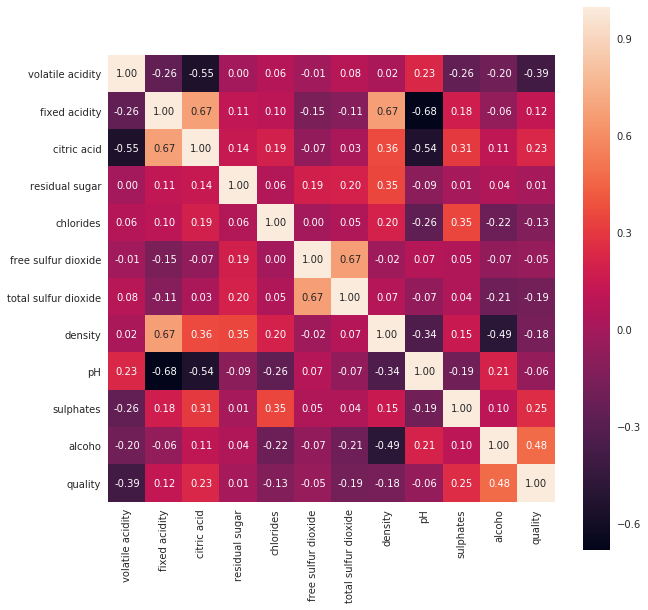

In [125]:
cols=['volatile acidity','fixed acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcoho','quality']

cm = np.corrcoef(data[cols].values.T)
#设置字的比例
plt.figure(figsize=(10,10))
sns.set(font_scale=1.0)
#绘制相关系数图
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt=".2f",
                 annot_kws={"size":10},yticklabels=cols,xticklabels=cols)
plt.show()


## 2.2绘图表示各个特征分别与标签之间的分布和回归关系

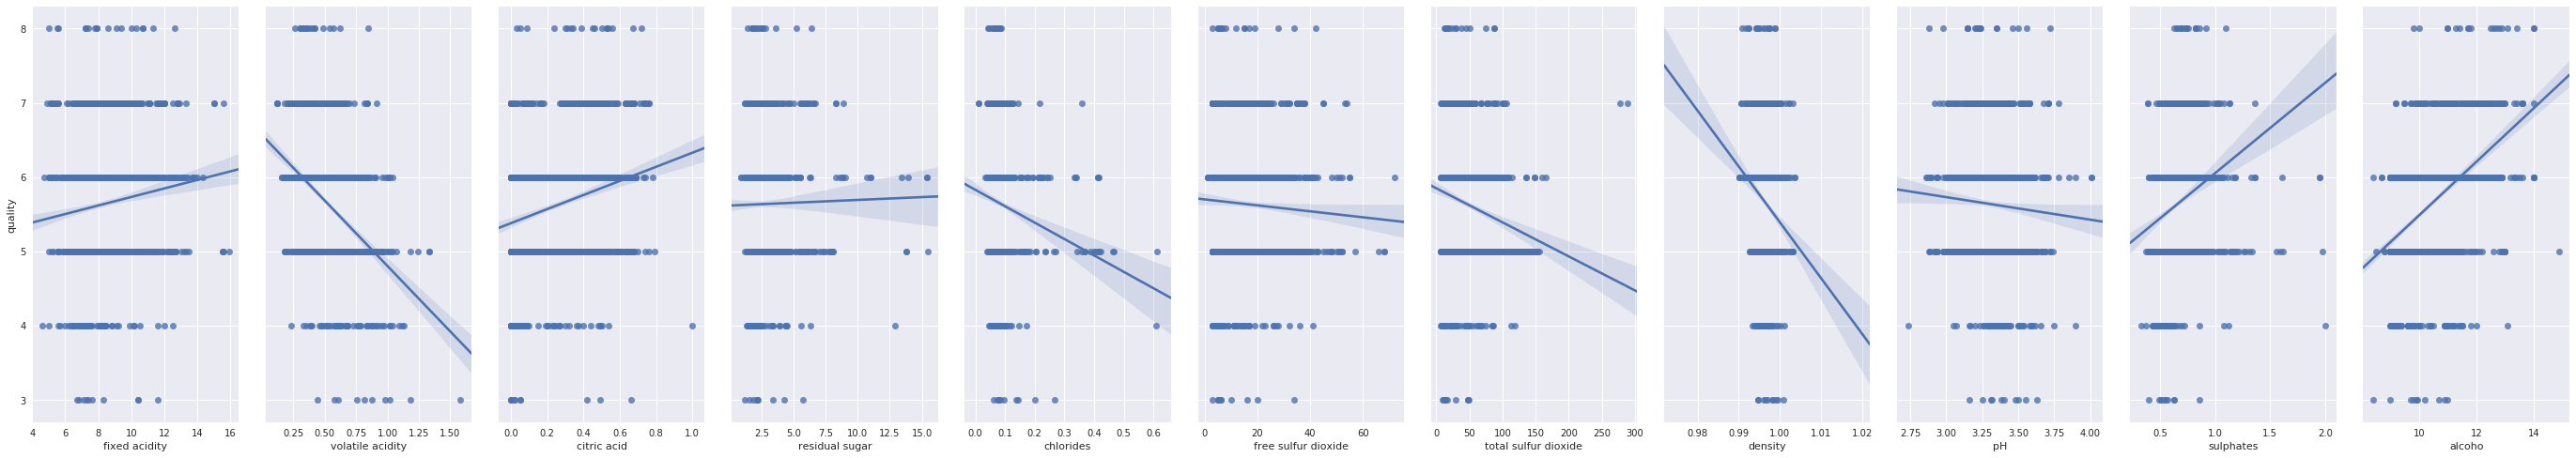

In [126]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcoho']
x = data[features]
y = data['quality']
sns.pairplot(data,x_vars=features,y_vars='quality',kind='reg',size=7,aspect=0.5)

## 2.3分析
从上面分布图和系数矩阵可以看到，'residual sugar'这一特征与标签的相关性最差，我们后续训练模型的时候可以考虑剔除此特征，具体分析见后续步骤

# 3.模型训练与评估
我们将数据集六二二分，分为训练集验证集和测试集，在训练集上进行训练，利用验证集进行模型调参，并将最终选好的参数在测试集上进行测试。

我们以平均绝对误差作为模型的评估指标，并画出各个模型的残差图。
平均绝对误差（Mean Absolute Deviation），又叫平均绝对离差，是所有单个观测值与算术平均值的偏差的绝对值的平均。

## 3.1数据集标准化、划分、并转为dataframe格式

In [127]:
data[features]=(data[features]-data[features].mean())/(data[features].std())
train_data, test_val_data= train_test_split(data,  test_size=0.4,random_state=888)   
val_data,test_data=train_test_split(test_val_data,  test_size=0.5,random_state=888) #数据集的百分之六十为训练集，百分之二十位验证集，百分之二十测试集
train_data_ = spark.createDataFrame(train_data)
val_data_ = spark.createDataFrame(val_data)
test_data_ = spark.createDataFrame(test_data)

In [128]:
train_data.head(5)

,volatile acidity,fixed acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcoho,quality
761,0.710263,0.562901,-0.054819,-0.383033,0.181635,-1.042237,-0.348995,0.335228,-0.395844,-1.408925,-0.772719,5
65,1.101194,-0.643269,-1.135591,1.496776,-0.030893,-1.137919,-1.079203,-0.290598,0.640773,-1.586668,0.447305,5
1526,-0.322912,-0.873016,-0.981195,-0.241161,-0.498453,0.201628,-0.257718,-0.645939,-0.071901,-0.046226,-0.772719,6
1533,-0.769690,-0.183776,0.151042,-0.453970,-0.285926,1.541176,1.141848,0.223852,0.511195,-0.283217,-1.335806,5
209,-1.272316,1.539325,1.592072,-0.312097,-0.710981,-0.850873,-0.835800,0.664051,-0.007113,1.316473,0.071913,7


## 3.2 利用验证集误差进行模型选择

In [129]:
def draw_residual_plots(regression_model,train_data,test_data,assembler):

    train_output = assembler.transform(train_data)
    train_features = train_output.select("features",train_output.quality.cast('double')).toDF('features','label')

    test_output = assembler.transform(test_data)
    test_features = test_output.select("features",test_output.quality.cast('double')).toDF('features','label')
    
    train_predict = regression_model.transform(train_features)
    test_predict = regression_model.transform(test_features)
    
    train_data = train_data.toPandas()
    test_data = test_data.toPandas()
    train_predict = train_predict.toPandas()
    test_predict= test_predict.toPandas()
    train_y_pred = np.array(train_predict['prediction'])
    test_y_pred = np.array(test_predict['prediction'])
    y_train = np.array(train_data['quality'])
    y_test = np.array(test_data['quality'])

    plt.scatter(train_y_pred,train_y_pred-y_train,c="blue",marker="o",label="test data")
    plt.scatter(test_y_pred,test_y_pred-y_test,c="lightgreen",marker="s",label="train data")
    plt.legend(loc="upper left")
    plt.hlines(y=0,xmin=0,xmax=10,lw=2,color="red")
    plt.xlim([0,10])
    plt.xlabel("predictive value")
    plt.ylabel("residual error")
    plt.show()
    plt.close()

def calculate_metric_value(regression_model, regression_df,inputcols):
    metric_dict={}
    assembler = pyspark.ml.feature.VectorAssembler(inputCols=inputcols, outputCol='features')
    output = assembler.transform(regression_df)
    label_features = output.select("features",output.quality.cast('double')).toDF('features','label')
    dataset = regression_model.transform(label_features)
    evaluator = RegressionEvaluator(predictionCol="prediction")
    metric_dict["mae"] = (evaluator.evaluate(dataset, {evaluator.metricName: "mae"}))

    return metric_dict

### 3.2.1线性回归模型训练与评估

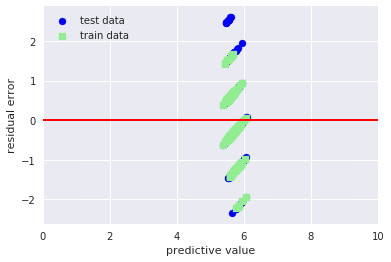

train: {'mae': 0.619197779010262}
val: {'mae': 0.6453896009890899}


In [130]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
inputcols=["fixed acidity", "volatile acidity","citric acid",'residual sugar',
                                                            "chlorides","free sulfur dioxide","total sulfur dioxide","density",
                                                             "pH","sulphates",'alcoho']
assembler = pyspark.ml.feature.VectorAssembler(inputCols=inputcols, outputCol='features')
output = assembler.transform(train_data_)
label_features = output.select("features", output.quality.cast('double')).toDF('features','label')

LRModel = lr.fit(label_features)
draw_residual_plots(LRModel,train_data_,val_data_,assembler)
metric_dict_test=calculate_metric_value(LRModel, val_data_,inputcols)
metric_dict_train=calculate_metric_value(LRModel, train_data_,inputcols)
print("train:",metric_dict_train)
print("val:",metric_dict_test)

### 3.2.2 随机森林回归模型训练与评估

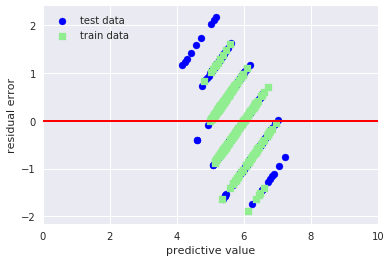

train: {'mae': 0.43603584841231596}
val: {'mae': 0.49778909960545314}


In [131]:
RFR = RandomForestRegressor()

inputcols=["fixed acidity", "volatile acidity","citric acid",'residual sugar',
                                                             "chlorides","free sulfur dioxide","total sulfur dioxide","density",
                                                             "pH","sulphates",'alcoho']
assembler = pyspark.ml.feature.VectorAssembler(inputCols=inputcols, outputCol='features')
output = assembler.transform(train_data_)
label_features = output.select("features", output.quality.cast('double')).toDF('features','label')


RFRModel = RFR.fit(label_features)

draw_residual_plots(RFRModel,train_data_,val_data_,assembler)
metric_dict_test=calculate_metric_value(RFRModel, val_data_,inputcols)
metric_dict_train=calculate_metric_value(RFRModel, train_data_,inputcols)
print("train:",metric_dict_train)
print("val:",metric_dict_test)

### 3.2.3gbt模型训练与评估
从下面可以看到，验证集误差和训练集误差相差较大，gbt模型可能已经过拟合。

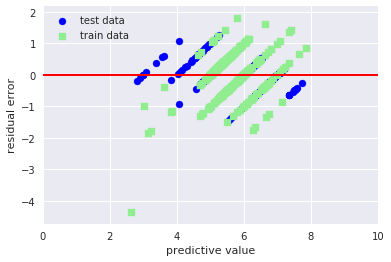

train: {'mae': 0.2714584291042317}
val: {'mae': 0.5124793408296222}


In [132]:
gbt = GBTRegressor()
inputcols=["fixed acidity", "volatile acidity","citric acid",'residual sugar',
                                                             "chlorides","free sulfur dioxide","total sulfur dioxide","density",
                                                             "pH","sulphates",'alcoho']
assembler = pyspark.ml.feature.VectorAssembler(inputCols=inputcols, outputCol='features')
output = assembler.transform(train_data_)
label_features = output.select("features", output.quality.cast('double')).toDF('features','label')


GBTModel = gbt.fit(label_features)

draw_residual_plots(GBTModel,train_data_,val_data_,assembler)
metric_dict_test=calculate_metric_value(GBTModel, val_data_,inputcols)
metric_dict_train=calculate_metric_value(GBTModel, train_data_,inputcols)
print("train:",metric_dict_train)
print("val:",metric_dict_test)

### 3.2.4 KNN回归模型训练与评估
KNN是moderlarts自研算法，knn回归模型读取数据以及训练过程如下所示

In [133]:
from modelarts_pyspark import KNNClassification,KNNRegression
from modelarts_pyspark.common import MeasurementType, Role, DataType, DfUtils, Meta, Attributes
from sklearn.metrics import mean_absolute_error

def get_schema(len_col,label_loc):
    schema=[]
    for i in range(1,len_col+1):
        if i!=label_loc:
            schema.append(dict(Meta('attr_'+str(i), MeasurementType.CONTINUOUS, DataType.INTEGER)))
        else:
            schema.append(dict(Meta('attr_'+str(i),  MeasurementType.CONTINUOUS, DataType.INTEGER, Role.TARGET)))
    return schema

schema=get_schema(12,12) #参数分别表示特征（包括标签）的列数，标签位于哪一列，此数据特征加标签一共12列，标签位于第12列
knn_regression_train_df = DfUtils.build_data_frame(sqlContext, train_data_, schema)
knn_regression_val_df=DfUtils.build_data_frame(sqlContext, val_data_, schema)

knn_regression = KNNRegression().set_k(5)  # set_k()后面可以设置KNN的超参数K值
KnnModel = knn_regression.fit(knn_regression_train_df)

knn_predict_train = KnnModel.transform(knn_regression_train_df)  #得到预测值
knn_predict_train=np.array(knn_predict_train.toPandas()) #将预测值转换为Numpy矩阵
train_data_label=np.array(train_data_.toPandas())[:,-1]
mae_train=mean_absolute_error(train_data_label,knn_predict_train)  #得到评估结果
print("train mae:",mae_train)

knn_predict_val = KnnModel.transform(knn_regression_val_df)
knn_predict_val=np.array(knn_predict_val.toPandas())
val_data_label=np.array(val_data_.toPandas())[:,-1]
mae_val=mean_absolute_error(val_data_label,knn_predict_val)
print("val mae:",mae_val)

train mae: 0.7565345846367744
val mae: 0.8146875000000001


### 3.2.4分析
可以看到，随机森林的baseline模型验证集集误差最小，对数据拟合更好，所以我们选定随机森林模型，并进一步进行调优

## 3.3特征筛选
从2.3的分析可以看到，'residual sugar'特征与标签相关性最低，所以我们用随机森林模型，观测剔除此特征与不剔除此特征在随机森林baseline模型上的误差变化。不剔除特征从上面3.2.2可以看到，验证集mae误差如上，下面我们将此特征剔除后，看看误差变为多少。

### 3.3.1剔除无关特征后再次训练模型

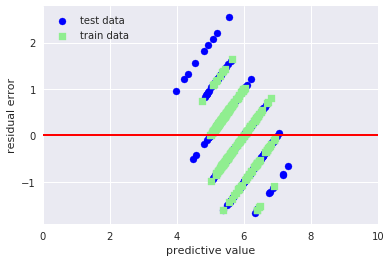

train: {'mae': 0.4408604504480212}
val: {'mae': 0.49789858495580414}


In [134]:
RFR = RandomForestRegressor(maxDepth =5)

inputcols=["fixed acidity", "volatile acidity","citric acid",
                                                             "chlorides","free sulfur dioxide","total sulfur dioxide","density",
                                                             "pH","sulphates",'alcoho']
assembler = pyspark.ml.feature.VectorAssembler(inputCols=inputcols, outputCol='features')
output = assembler.transform(train_data_)
label_features = output.select("features", output.quality.cast('double')).toDF('features','label')


RFRModel = RFR.fit(label_features)

draw_residual_plots(RFRModel,train_data_,val_data_,assembler)
metric_dict_test=calculate_metric_value(RFRModel, val_data_,inputcols)
metric_dict_train=calculate_metric_value(RFRModel, train_data_,inputcols)
print("train:",metric_dict_train)
print("val:",metric_dict_test)

### 3.3.2分析
可以看到，剔除'residual sugar'后，验证集误差略有减小，且本身此特征与标签相关性很低，所以我们剔除此特征，之后的训练过程不再涉及此特征。另外特征中“Ph”、'fixed acidity'值与标签相关性也不大，如果有感兴趣的读者可以试试剔除这两个标签之后对模型准确度有何影响

## 3.4 利用验证集误差进行模型调参
剔除无关特征后，我们对随机森林进行进一步调参。
我们对算法的两个参数进行调参：numTrees，maxDepth。

numTrees（决策树的个数）：决策树的个数越多，结果的方差越小，越能对抗过拟合，同时，训练的时间也随着个数增加而增加。 

maxDepth：是指森林中每一棵决策树最大深度。更深的一棵树意味模型更倾向于过拟合。

由于随机森林有效对抗过拟合，所以一般树的深度可以很大。


In [135]:
def get_mae_rf(num_tree,num_adh,train_features,inputcols,test_data_):

    gbt = RandomForestRegressor(numTrees =num_tree, maxDepth =num_adh)

    gbtModel = gbt.fit(train_features)

    metric_dict_test=calculate_metric_value(gbtModel, val_data_,inputcols)

    return(metric_dict_test['mae'])

inputcols=["fixed acidity", "volatile acidity","citric acid",
                                                             "chlorides","free sulfur dioxide","total sulfur dioxide","density",
                                                             "pH","sulphates",'alcoho']
assembler = pyspark.ml.feature.VectorAssembler(inputCols=inputcols, outputCol='features')
output = assembler.transform(train_data_)
label_features = output.select("features", output.quality.cast('double')).toDF('features','label')


### 3.4.1对决策树个数调参
我们将决策树深度定为函数本身默认值20，从（2,50）范围内搜索决策树个数，并以此值训练训练集，然后对验证集进行测试，找到使验证集mae值最小的决策树个数。

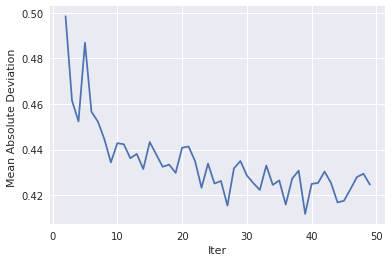

plot_mae_num_tree_sorted: [(39, 0.4117988782051281), (27, 0.4154513888888891), (36, 0.41589640696068886), (44, 0.4168335700757577), (45, 0.41758838383838376), (32, 0.422314453125), (46, 0.42264996617739714), (23, 0.4232676630434783), (34, 0.42450776143790847), (49, 0.42463860544217696), (40, 0.4249528945324196), (25, 0.42511607142857155), (31, 0.4253024193548386), (43, 0.42532262472669463), (41, 0.42540650406504066), (26, 0.4262219551282052), (35, 0.42647321428571433), (37, 0.42726914414414424), (47, 0.42796364167099094), (30, 0.4286458333333332), (48, 0.42940484614928404), (19, 0.4297971491228072), (42, 0.4303571428571429), (38, 0.4307565789473686), (14, 0.4314732142857142), (28, 0.4317362882653063), (17, 0.4324632352941175), (33, 0.43300189393939414), (18, 0.4334143518518519), (24, 0.4338541666666666), (9, 0.4343749999999999), (22, 0.43494318181818203), (29, 0.4349799615230399), (12, 0.4361979166666668), (16, 0.437890625), (13, 0.43810096153846184), (20, 0.4408072916666665), (21, 0.4

In [136]:
plot_mae_num_tree = {}
for num_tree  in range(2,50):
    my_mae = get_mae_rf(num_tree,20,label_features,inputcols,val_data_)
    plot_mae_num_tree[num_tree] = my_mae
    
plt.plot(list(plot_mae_num_tree.keys()),plot_mae_num_tree.values())
plt.xlabel("Iter")
plt.ylabel("Mean Absolute Deviation ")
plt.show()
plot_mae_num_tree_sorted = sorted(plot_mae_num_tree.items(),key=itemgetter(1))
print("plot_mae_num_tree_sorted:",plot_mae_num_tree_sorted)

my_num_tree=plot_mae_num_tree_sorted[0][0]   ## 误差最小的决策树个数
print("my_num_tree:",my_num_tree)

### 3.4.2 对最大深度调参
我们可以从上面得到，当最大深度为20时，我们可以得到，决策树个数为 my_num_tree 时，验证集绝对平均误差最小，所以我们将决策树个数定位 my_num_tree ，然后再从（2,30）范围内搜索最大深度。

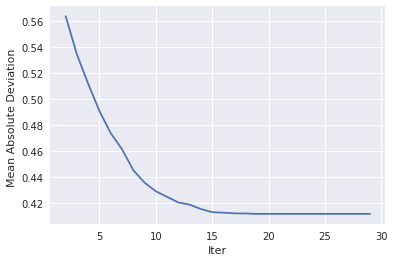

plot_mae_num_adh_sorted [(19, 0.411759421134421), (21, 0.41177884615384597), (22, 0.41177884615384597), (23, 0.41177884615384597), (24, 0.41177884615384597), (25, 0.41177884615384597), (26, 0.41177884615384597), (27, 0.41177884615384597), (28, 0.41177884615384597), (29, 0.41177884615384597), (20, 0.4117988782051281), (18, 0.4121051215522368), (17, 0.41218599637296605), (16, 0.4127107873881036), (15, 0.4130998769179529), (14, 0.4155194204337077), (13, 0.4188849939968137), (12, 0.4205657097851569), (11, 0.42483534887334307), (10, 0.4291626991887297), (9, 0.43577159509640706), (8, 0.4453523896189984), (7, 0.4614786759266961), (6, 0.473745694589269), (5, 0.49075113586572605), (4, 0.5117019934734286), (3, 0.5342361280792266), (2, 0.5636701252640647)]
my_num_adh: 19


In [137]:
plot_mae_num_adh = {}

for num_adh  in range(2,30):
    my_mae = get_mae_rf(my_num_tree,num_adh,label_features,inputcols,val_data_)   #这里my_num_tree是39
    plot_mae_num_adh[num_adh] = my_mae
    
plt.plot(list(plot_mae_num_adh.keys()),plot_mae_num_adh.values())
plt.xlabel("Iter")
plt.ylabel("Mean Absolute Deviation ")
plt.show()
plot_mae_num_adh_sorted = sorted(plot_mae_num_adh.items(),key=itemgetter(1))
print("plot_mae_num_adh_sorted",plot_mae_num_adh_sorted)

my_num_adh=plot_mae_num_adh_sorted[0][0]
print("my_num_adh:",my_num_adh)

### 3.4.3确定参数
可以看到 决策树个数为 my_num_tree ，最大深度为 my_num_adh 时，有最小误差，所以我们最后的参数定为 numTrees =my_num_tree, maxDepth =my_num_adh。
另外我这里是决策树个数和最大深度分别进行选择，也可以用网格搜索法，将这两个值两两组合为不同的组合，然后判断哪种组合验证集误差最小，但是这种方法肯定更费时间，有兴趣的读者可以下去自己调试。

## 3.5模型确定后重新训练，并在测试集上进行测试
上面我们确定了决策树和最大深度，并把它们分别保存在了 my_num_tree和my_num_adh中，确定参数后重新训练模型作为最后的模型。并观测测试集误差是多少。

In [138]:
RFR = RandomForestRegressor(numTrees =my_num_tree, maxDepth =my_num_adh)

inputcols=["fixed acidity", "volatile acidity","citric acid",
                                                             "chlorides","free sulfur dioxide","total sulfur dioxide","density",
                                                             "pH","sulphates",'alcoho']
assembler = pyspark.ml.feature.VectorAssembler(inputCols=inputcols, outputCol='features')
output = assembler.transform(train_data_)
label_features = output.select("features", output.quality.cast('double')).toDF('features','label')


RFRModel = RFR.fit(label_features)


metric_dict_val=calculate_metric_value(RFRModel, val_data_,inputcols) # 验证集误差
print("val mae:",metric_dict_val)
metric_dict_test=calculate_metric_value(RFRModel, test_data_,inputcols)   #测试集误差
print("test mae:",metric_dict_test)


val mae: {'mae': 0.411759421134421}
test mae: {'mae': 0.43901705932955937}


### 对比一下没进行过调优的模型在测试集上的误差
可以看到，调过优的模型测试集的误差显然更小

In [139]:
from numpy import allclose
from pyspark.ml.linalg import Vectors

RFR = RandomForestRegressor()

inputcols=["fixed acidity", "volatile acidity","citric acid",'residual sugar',
                                                             "chlorides","free sulfur dioxide","total sulfur dioxide","density",
                                                             "pH","sulphates",'alcoho']
assembler = pyspark.ml.feature.VectorAssembler(inputCols=inputcols, outputCol='features')
output = assembler.transform(train_data_)
label_features = output.select("features", output.quality.cast('double')).toDF('features','label')


RFRModel = RFR.fit(label_features)

metric_dict_val=calculate_metric_value(RFRModel, val_data_,inputcols) # 验证集误差
print("val mae:",metric_dict_val)
metric_dict_test=calculate_metric_value(RFRModel, test_data_,inputcols) #测试集误差
print("test mae:",metric_dict_test)

val mae: {'mae': 0.49778909960545314}
test mae: {'mae': 0.4810245253751081}
